# Question 1(a)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

### To ignore any warning

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv("parkingLot.csv")
df

vehicle_no   timestamp             camera_id
0       MHUN7063     2024-09-12 05:00:00           1
1       MHYN4677     2024-09-12 05:00:00           1
2       MHEL6595     2024-09-12 05:00:00           1
3       MHNQ2590     2024-09-12 05:00:00           1
4       MHHA0518     2024-09-12 05:00:00           1
...             ...                   ...        ...
106689  MHCN7114     2024-11-14 00:00:00           2
106690  MHVY8418     2024-11-14 00:00:00           2
106691  MHSR8102     2024-11-14 00:00:00           2
106692  MHQG5264     2024-11-14 00:00:00           2
106693  MHLX0117     2024-11-14 00:00:00           2

[106694 rows x 3 columns]

In [5]:
print(df.info())
print(df.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106694 entries, 0 to 106693
Data columns (total 3 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   vehicle_no            106694 non-null  object
 1   timestamp             106694 non-null  object
 2   camera_id             106694 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.4+ MB
None
Index(['vehicle_no ', 'timestamp           ', 'camera_id'], dtype='object')


## Data precrocessing


- Converted time to datetime
- Removed unnecessary space from each record
- sorted the data according to timestamp

In [6]:
df['timestamp'] = df['timestamp           '].str.upper().astype('string')
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df['vehicle_no'] = df['vehicle_no '].str.strip()
df = df.drop('vehicle_no ', axis=1)
df = df.drop('timestamp           ', axis=1)
df = df.sort_values(by='timestamp')
df

camera_id           timestamp vehicle_no
0               1 2024-09-12 05:00:00   MHUN7063
21              1 2024-09-12 05:00:00   MHMY1867
20              1 2024-09-12 05:00:00   MHZF8417
19              1 2024-09-12 05:00:00   MHFU6425
18              1 2024-09-12 05:00:00   MHHB4038
...           ...                 ...        ...
106675          2 2024-11-14 00:00:00   MHEV1001
106674          2 2024-11-14 00:00:00   MHGL7893
106692          2 2024-11-14 00:00:00   MHQG5264
106682          2 2024-11-14 00:00:00   MHBB9719
106693          2 2024-11-14 00:00:00   MHLX0117

[106694 rows x 3 columns]

For this question, it is enough to only read the number of cars entering, the vehicle_no does not matter as long as we get the count of the vehicles. So, it is enough to just take the values from the camera_id 1 and group them according to the date

In [7]:

df['date'] = df['timestamp'].dt.date

entries_df = df[df['camera_id'] == 1]

vehicles_per_day = entries_df.groupby('date')['vehicle_no'].count()
vehicles_per_day


date
2024-09-12     886
2024-09-13     809
2024-09-14     925
2024-09-15    1073
2024-09-16     843
              ... 
2024-11-09     906
2024-11-10     944
2024-11-11     828
2024-11-12     806
2024-11-13     781
Name: vehicle_no, Length: 63, dtype: int64

### Plot of number of cars entering each day 

In [8]:
vehicles_per_day.plot(kind='line')

<Axes: xlabel='date'>

### Autocorrelation plot for each lag value

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

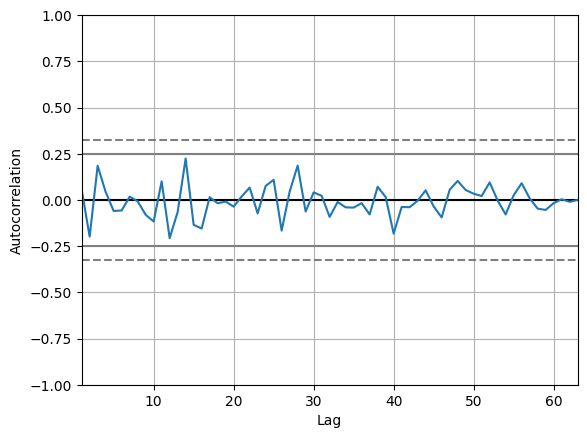

In [9]:

import statsmodels.api as sm
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(vehicles_per_day)


## Forecasting
From the auto correlation plot and the vehicles per day plot, we trained the ARIMA model on the following parameters (in the form (p,d,q)).
- (1,0,1)
- (2,0,0)
- (2,0,1)

We splited the dataset into train-test with ratio 0.8:0.2, and reported the mean absolute error at the end.

In [10]:



from sklearn.metrics import mean_absolute_error

X = vehicles_per_day.values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]




history = [x for x in train]
predictions1 = list()
for t in range(len(test)):
    model = sm.tsa.arima.ARIMA(history, order=(1,0,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions1.append(yhat)
    obs = test[t]
    history.append(obs)
print(mean_absolute_error(test, predictions1))

history = [x for x in train]
predictions2 = list()
for t in range(len(test)):
    model = sm.tsa.arima.ARIMA(history, order=(2,0,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions2.append(yhat)
    obs = test[t]
    history.append(obs)
print(mean_absolute_error(test, predictions2))

history = [x for x in train]
predictions3 = list()
for t in range(len(test)):
    model = sm.tsa.arima.ARIMA(history, order=(2,0,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions3.append(yhat)
    obs = test[t]
    history.append(obs)
print(mean_absolute_error(test, predictions3))

46.17630261016305
42.678936805526554


C:\Users\vaibh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


45.973235696815145


### Plot between the best prediction and the actual values 

We got the best result for (p,d,q) = (2,0,0)

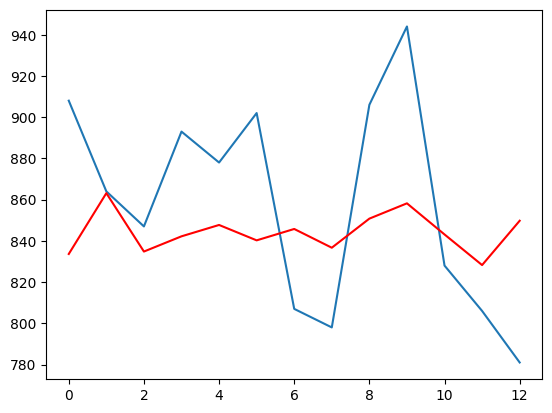

In [12]:
plt.plot(test)
plt.plot(predictions2, color='red')
plt.show()

## MASE and MAPE

In [14]:

import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def MASE(y_true, y_pred, y_train):
    mae = mean_absolute_error(y_true, y_pred)
    naive_forecast = np.roll(y_train, 1)[1:]  
    naive_mae = mean_absolute_error(y_train[1:], naive_forecast)
    mase = mae / naive_mae
    return mase

print("MAPE: ", mean_absolute_percentage_error(test, predictions1))
print("MASE: ", MASE(test, predictions1, train))


MAPE:  5.349685330136059
MASE:  0.6598538430731961


#### Forecast for the next 7 days

In [16]:
# Use this model to predict the next 7 days

history = [x for x in X]
predictions = list()
for t in range(7):
    model = sm.tsa.arima.ARIMA(history, order=(2,0,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    history.append(yhat)

In [17]:
print(predictions)

[850.8292789321715, 860.6225495876141, 847.1985543290906, 844.307261183477, 846.8215998453629, 847.5771843024119, 847.1203304875975]
